<a href="https://colab.research.google.com/github/Xavier-ML/Computational-Physics-with-Python/blob/main/09b_MC_magnet_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating a magnet using a Monte Carlo algorithm

- by Börge Göbel

In [73]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

(-1.1, 1.1)

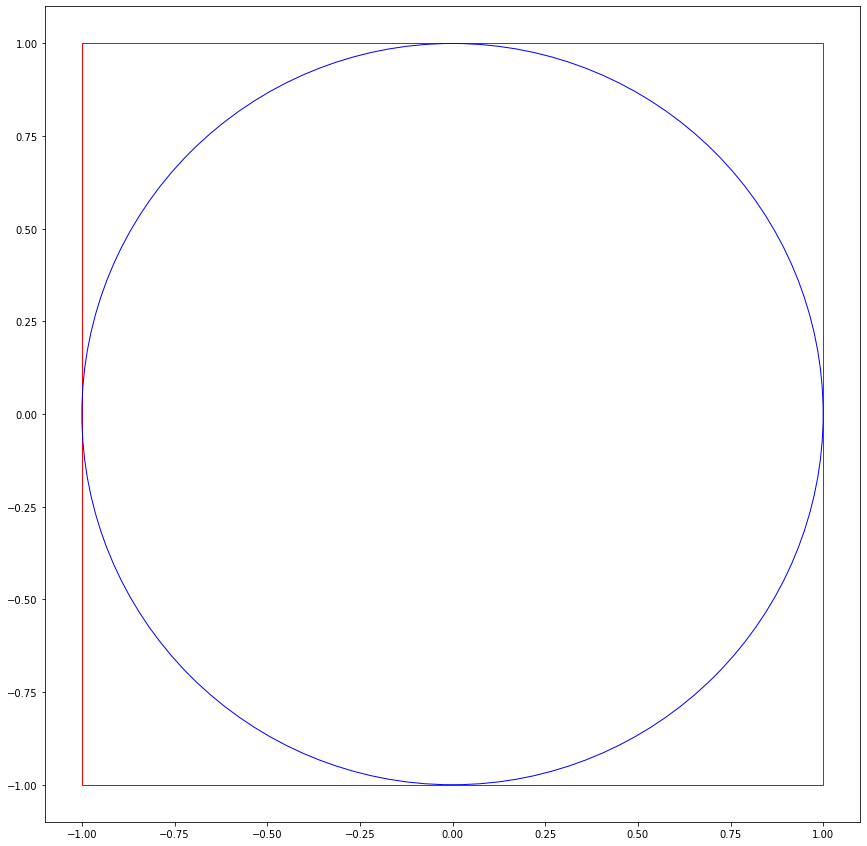

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect = "equal")
plt.rcParams['figure.figsize'] = [15, 15]

rectangle = patches.Rectangle((-1,-1),2,2,facecolor = "none", edgecolor = "red")
ax.add_patch(rectangle)

circle = patches.Circle((0,0),1,facecolor = "none", edgecolor = "blue")
ax.add_patch(circle)

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

**Measure the area ratio by counting randomly generated points**

In [75]:
points = 1000

rand = 2*np.random.rand( 2*points) -1

In [76]:
rand

array([-0.29479225,  0.43455179, -0.3691107 , ...,  0.89176417,
        0.50076484, -0.55749421])

In [77]:
randpoints = rand.reshape(points, 2)

In [78]:
randpoints

array([[-0.29479225,  0.43455179],
       [-0.3691107 ,  0.28696421],
       [-0.92879366, -0.71865921],
       ...,
       [-0.83511075, -0.11021981],
       [-0.70412022,  0.89176417],
       [ 0.50076484, -0.55749421]])

In [79]:
normpoints = randpoints[:,0]**2 + randpoints[:,1]**2

In [80]:
normpoints[0]

0.27573772909429817

In [81]:
pointsOut = randpoints[normpoints > 1]
pointsIn = randpoints[normpoints <= 1]

In [82]:
piapprox = 4*len(pointsIn)/points
print(piapprox)

3.204


In [83]:
piapprox - np.pi

0.062407346410207065

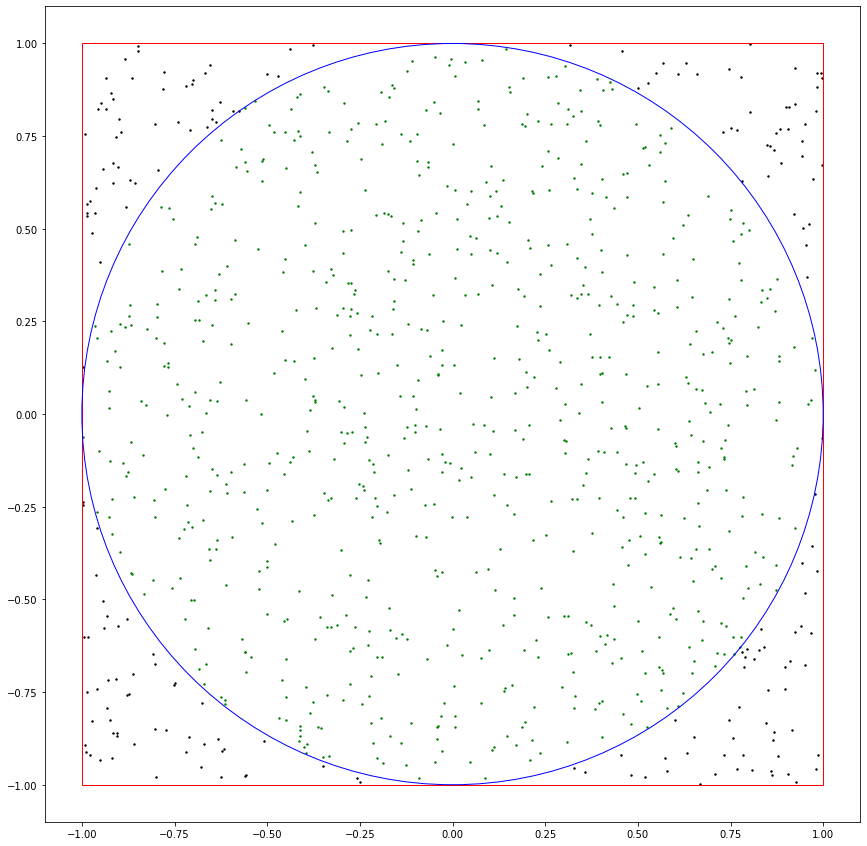

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect = "equal")
plt.rcParams['figure.figsize'] = [10, 10]

rectangle = patches.Rectangle((-1,-1),2,2,facecolor = "none", edgecolor = "red")
ax.add_patch(rectangle)

circle = patches.Circle((0,0),1,facecolor = "none", edgecolor = "blue")
ax.add_patch(circle)

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

plt.scatter(pointsIn[:,0],pointsIn[:,1], color = "green", s=2)
plt.scatter(pointsOut[:,0],pointsOut[:,1], color = "black", s=2)

**Alternative: Loop method**

In [85]:
i=0
counter = 0

while i<=points:
    if np.linalg.norm(np.random.rand(2)-1) < 1:
        counter = counter + 1
    i = i + 1


In [86]:
piapprox = 4*counter/points
print(piapprox)

3.168


**Comparative method over time**

In [87]:
%%timeit

rand = 2*np.random.rand( 2*points) -1
randpoints = rand.reshape(points, 2)
normpoints = randpoints[:,0]**2 + randpoints[:,1]**2
pointsIn = randpoints[normpoints <= 1]
piapprox = 4*len(pointsIn)/points

54.5 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Loop method

In [88]:
%%timeit

i=0
counter = 0

while i<=points:
    if np.linalg.norm(np.random.rand(2)-1) < 1:
        counter = counter + 1
    i = i + 1

piapprox = 4*counter/points

10.2 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 1. Generate starting configuration

We start with a randomly generated array of magnetic moments \\( \{ \vec{m}_1, \vec{m}_2, \dots, \vec{m}_n \} \\). The length of each moment is fixed \\( |\vec{m}_i| = 1 \\) but the orientation is chosen randomly. We can construct this by generating a random polar angle \\( \varphi_i \\) and azimutal angle \\( \theta_i \\) and using spherical coordinates:

\\( \vec{m}_i = \begin{pmatrix} \cos\varphi_i\sin\theta_i \\ \sin\varphi_i\sin\theta_i \\ \cos\theta_i \end{pmatrix} \\)

In [89]:
length = 20
num = length**2

randphi = 2*np.pi*np.random.rand(num).reshape(length,length, 1)
randtheta = np.pi*np.random.rand(num).reshape(length,length,1 )

In [90]:
randtheta.shape

(20, 20, 1)

### Magnetic moments

In [91]:
mag = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta)])

In [92]:
mag[:,5,2,0]

array([0.12893544, 0.95036509, 0.28316398])

In [93]:
# check norm
np.sqrt( mag[0,:]**2 + mag[1,:]**2 + mag[2,:]**2 )[5,2,0]

0.9999999999999999

### Positions

In [94]:
coords = np.array(np.meshgrid(np.arange(length), np.arange(length),np.arange(1)))

### Plot

In [95]:
# Change standard size of all figures in this notebook
plt.rcParams['figure.figsize'] = [40, 15]

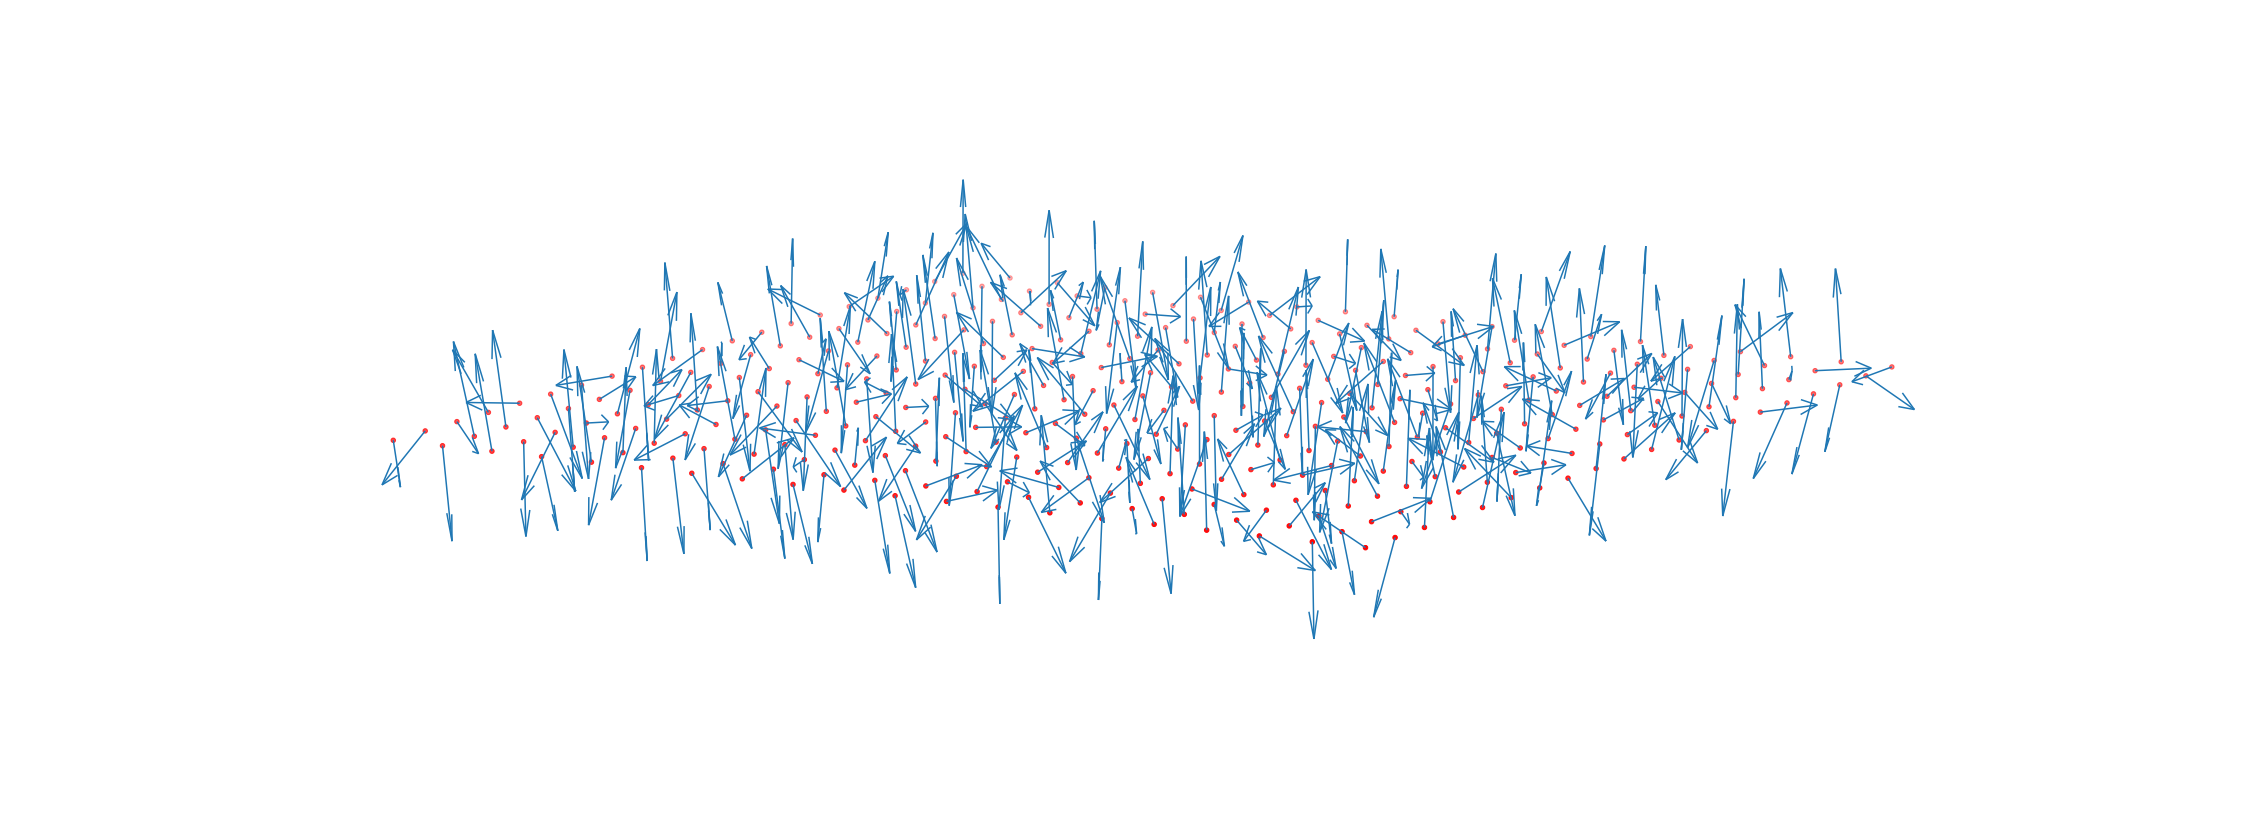

In [96]:
arrowplot = plt.axes(projection = "3d")
arrowplot.set_zlim(-2,2)
#arrowplot.set_box_aspect(aspect = (length, length, 2))

# make background invisible
arrowplot.axis(False)

#Quiver plot
arrowplot.quiver(
    coords[0],coords[1],coords[2],
    mag[0],mag[1],mag[2]
)

# Coordinate plot
arrowplot.scatter3D(coords[0],coords[1],coords[2], color = "red")

## 2. Calculating the energy 

We are searching for the configuration with the lowest energy. For a ferromagnet the energy can be written as:

\\( -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j \\) 

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)\\)

Every moment is interacting with its direct neighbor (\\( <i,j> \\)) and prefers a parallel orientation as long as \\( J > 0\\). Of course, there exist additional energy terms that have to be considered for a realistic ferromagnet but we will neglect them for now. 

In [97]:
J=1

In [98]:
-0.5*J*np.dot( mag[:,5,2,0],mag[:,6,2,0] + mag[:,4,2,0] + mag[:,5,3,0] + mag[:,5,1,0] )

-1.0115989566348094

In [99]:
-0.5*J*np.dot( mag[:,(length-1)%length,2,0],mag[:,length%length,2,0] + mag[:,(length-2)%length,2,0] + mag[:,(length-1)%length,3,0] + mag[:,(length-1)%length,1,0] )

-0.30707954156180917

In [100]:
def energyExchangeContribution(mag,x,y):
    return -0.5*J*np.dot( mag[:,x,y,0], mag[:,(x+1)%length,y,0] + mag[:,(x-1)%length,y,0] + mag[:,x,(y+1)%length,0] + mag[:,x,(y-1)%length,0])

def energyExchange(mag):
    # mag: Array magnetic moments
    energy = 0
    for x in range(length):
        for y in range(length):
            energy = energy + energyExchangeContribution(mag,x,y)
    return energy

In [101]:
energyExchange(mag)

7.531243790920592

In [102]:
mag[:,6,2,0]

array([-0.93182117,  0.3085044 , -0.19113958])

In [103]:
mag.shape

(3, 20, 20, 1)

__Update 2 (skip for the beginning):__ We can apply an external magnetic field \\( \vec{B} \\). This leads to the energy:

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu \sum_i \vec{B}\cdot \vec{m}_i \\) 


__Update 3 (skip for the beginning):__ We include the Dzyaloshinskii–Moriya interaction (asymmetric exchange).

\\( H = -\frac{1}{2}J\sum_{<i,j>}\vec{m}_i\cdot\vec{m}_j - \mu B \sum_i m_i^{(z)}  + \frac{1}{2}\sum_{<i,j>}\vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right)\\) 

The vectors \\( \vec{D}_{ij} \\) are determined by the symmetry of the sample. In our example, they shall point along the direction \\( i \rightarrow j\\). 

As an example, let us consider a bond along the \\( x \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_x \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(y)}m_j^{(z)} - m_i^{(z)}m_j^{(y)} \right)\\) 

For a bond along the \\( y \\) direction:

\\( \vec{D}_{ij}\cdot\left(\vec{m}_i\times\vec{m}_j\right) = D \vec{e}_y \cdot \left(\vec{m}_i\times\vec{m}_j\right) = D \left( m_i^{(z)}m_j^{(x)} - m_i^{(x)}m_j^{(z)} \right)\\) 

## 3. Metropolis step

Now to the actual Monte Carlo algorithm. We will repeditly do so-called Metropolis steps: 

1. A random magnetic moment is selected.
2. It is reoriented along a random direction.
3. The energy is calculated \\( E_\mathrm{new} \\).
4. The energy is compared to the old energy \\( E_\mathrm{old} \\): 
    - If the energy is decreased, the random change of the magnetic moment is accepted. 
    - If the energy is increased, the old magnetic moment is restored.

In [126]:
def stepExchange(mag):
    #1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energyold = 2*energyExchangeContribution(mag,x,y)
    #2.
    randphi = 2*np.pi*np.random.rand()
    randtheta = np.pi*np.random.rand()
    # Problem with the ids: savemag = mag[:,x,y,0] ==> savemag will be changed once mag[:,x,y,0] is changed in the next line
    savemag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta)])
    #3.
    energynew = 2*energyExchangeContribution(mag,x,y)
    #4.
    if (energynew < energyold):
        # accept the change & update the energy
        ### energy
        energychange = energynew - energyold
    else:
        # decline & restore old moment
        mag[:,x,y,0] = savemag
        energychange = 0
    return [mag, energychange]


In [127]:
stepExchange(mag)[1]

0

__Update 1 (skip for the beginning):__ For finite temperatures \\( T \\), we accept the change with a chance \\( \exp\left(-\frac{E_\mathrm{new}-E_\mathrm{old}}{k_BT}\right) \\)

In [128]:
def stepExchangeT(mag,kBtemp):
    #1.
    x = np.random.randint(length)
    y = np.random.randint(length)
    energyold = 2*energyExchangeContribution(mag,x,y)
    #2.
    randphi = 2*np.pi*np.random.rand()
    randtheta = np.pi*np.random.rand()
    # Problem with the ids: savemag = mag[:,x,y,0] ==> savemag will be changed once mag[:,x,y,0] is changed in the next line
    savemag = np.array(mag[:,x,y,0])
    mag[:,x,y,0] = np.array([ np.cos(randphi)*np.sin(randtheta), np.sin(randphi)*np.sin(randtheta), np.cos(randtheta)])
    #3.
    energynew = 2*energyExchangeContribution(mag,x,y)
    #4.
    if (energynew < energyold):
        # accept the change & update the energy
        ### energy
        energychange = energynew - energyold
    else:
        if np.random.rand() < np.exp( -(energynew - energyold)/kBtemp):
            # accept the change & update the energy
            energychange = energynew - energyold
        else:
            # decline & restore old moment
            mag[:,x,y,0] = savemag
            energychange = 0
    return [mag, energychange]

__Update 2 (skip for the beginning):__ We include the energy corresponding to the interaction with the magnetic field:

__Update 3 (skip for the beginning):__ We include the energy corresponding to the Dzyaloshinskii–Moriya interaction (asymmetric exchange):

## 4. Run the Monte Carlo algorithm

In [137]:
numberSteps = 5000000


#optional
energy = energyExchange(mag)
energyList = [energy]

for i in range(numberSteps):
    # mag, energychange = stepExchange(mag) # Inicial version: zero temperature
    kBtemp = 0.1*(1-i/numberSteps)
    mag, energychange = stepExchangeT(mag,kBtemp)   # Update 1: Consider finite temperature 
    # optional
    energy = energy + energychange
    energyList.append(energy)

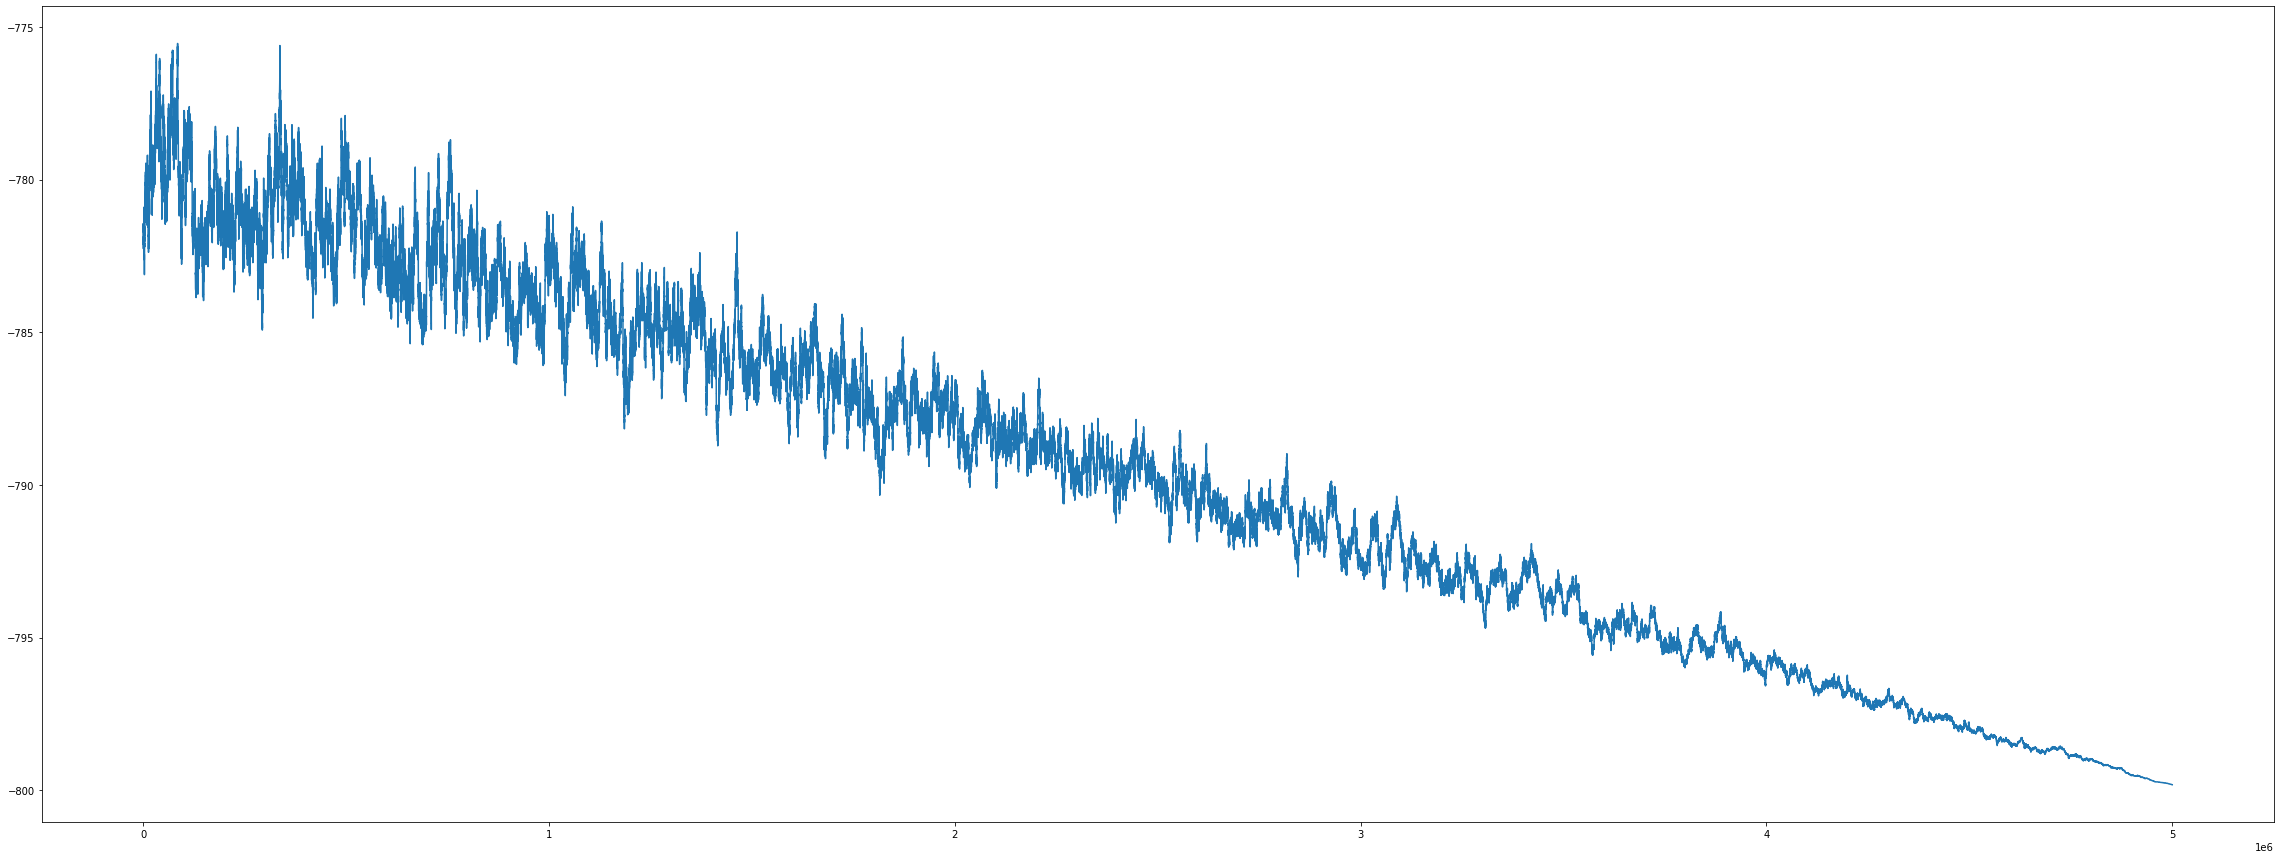

In [138]:
plt.plot(range(numberSteps+1), energyList)

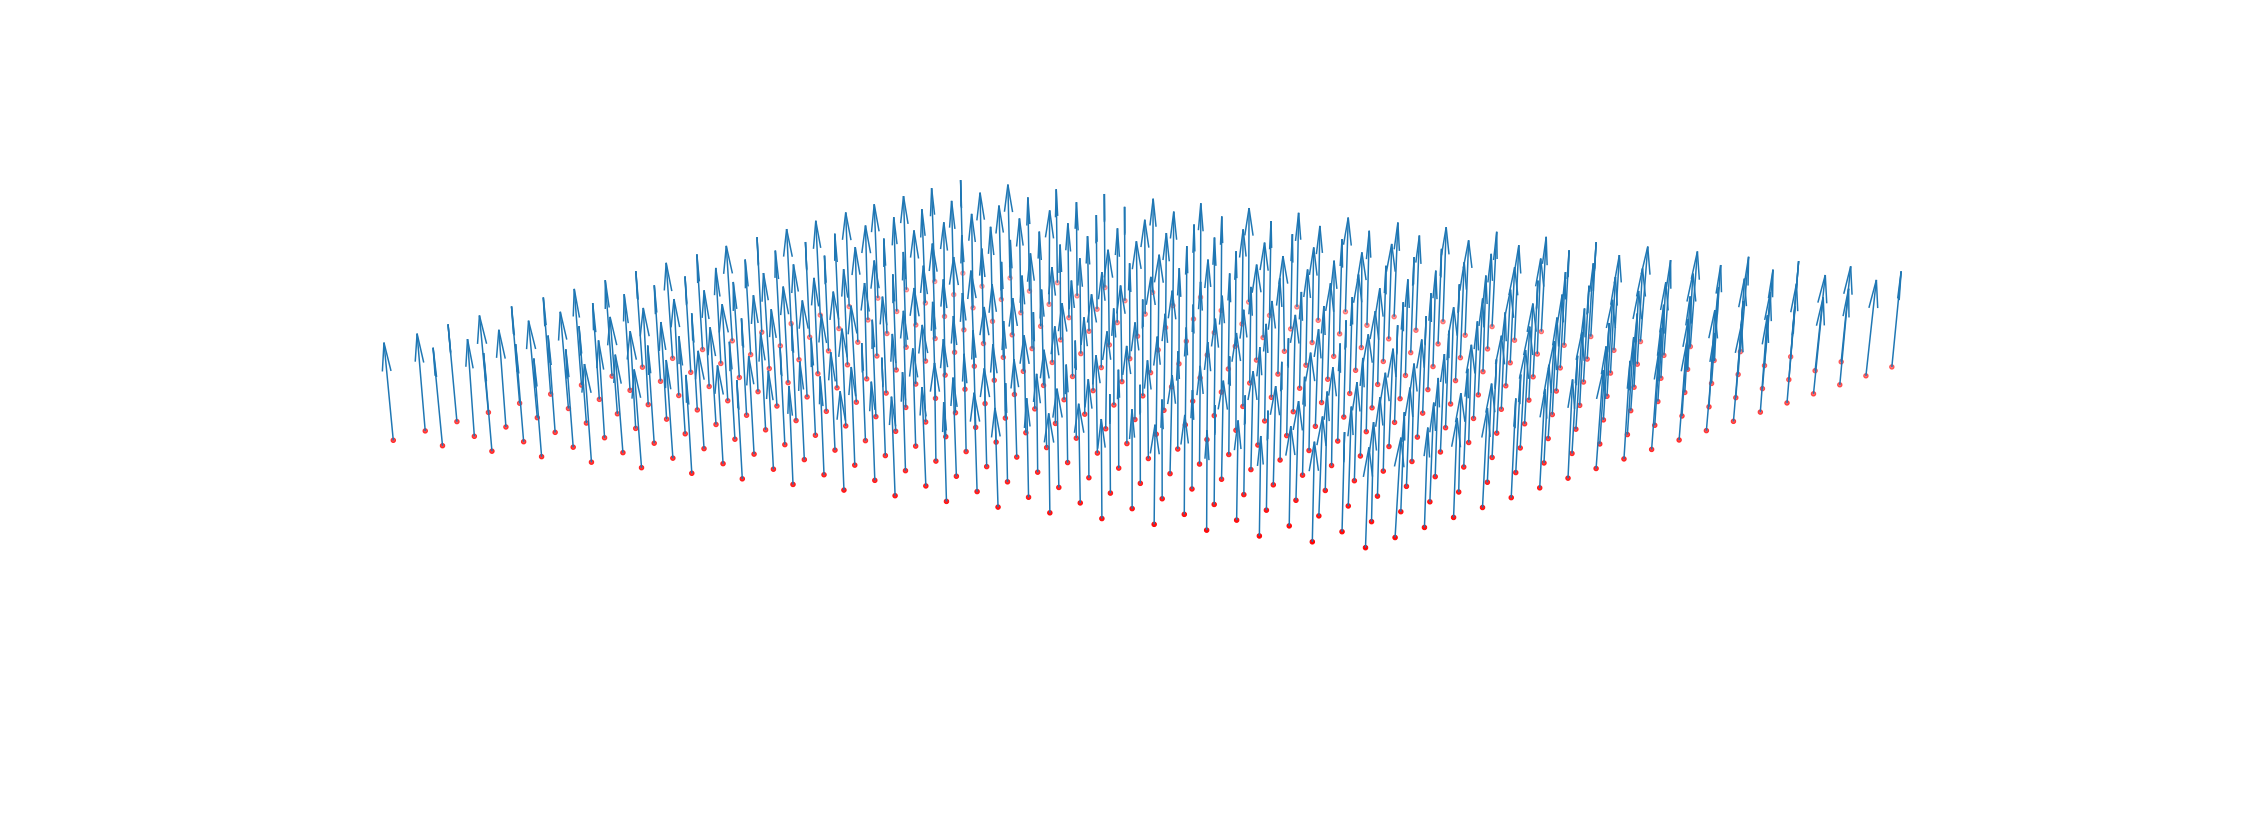

In [139]:
arrowplot = plt.axes(projection = "3d")
arrowplot.set_zlim(-2,2)
#arrowplot.set_box_aspect(aspect = (length, length, 2))

# make background invisible
arrowplot.axis(False)

#Quiver plot
arrowplot.quiver(
    coords[0],coords[1],coords[2],
    mag[0],mag[1],mag[2]
)

# Coordinate plot
arrowplot.scatter3D(coords[0],coords[1],coords[2], color = "red")

In [140]:
energyList[-1]

-799.8184733683527

In [141]:
energyExchange(mag)

-799.8184733683529